# Deploy a Python function to IBM Watson Machine Learning (MNIST tutorial)

Create and deploy a function that receives HTML canvas image data from a web app and then processes and sends that data to a model trained to recognize handwritten digits.

This notebook runs on Python 3.5.

See: <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-deployed-func-mnist-tutorial.html" target="_blank">MNIST function deployment tutorial</a>

1. [Install and import required packages and libraries](#step1)
2. [Instantiate a Watson Machine Learning client object](#step2)
3. [Get an endpoint URL for a model deployment](#step3)
4. [Get sample canvas data](#step4)
5. [Create a deployable function](#step5)
6. [Store and deploy the function](#step6)
7. [Test the deployed function](#step7)

## <a id="step1"></a> 1. Install and import required packages and libraries

In [ ]:
!pip install --upgrade wget

In [2]:
import os, wget, json
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import numpy as np
import matplotlib.pyplot as plt
import requests

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## <a id="step2"></a> 2. Instantiate a Watson Machine Learning client object

Paste your Watson Machine Learning credentials in the following cell.

See: <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-get-wml-credentials.html" target="_blank">Looking up credentials</a>

In [ ]:
wml_credentials = {
    "instance_id" : "",
    "password"    : "",
    "url"         : "",
    "username"    : ""
}
client = WatsonMachineLearningAPIClient( wml_credentials )

## 3. <a id="step3"></a> Get an endpoint URL for a model deployment

The deployed function created in this notebook is designed to send payload data to a TensorFlow model created in the <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-mnist-tutorials.html" target="_blank" rel="noopener noreferrer">MNIST tutorials</a>.

### Option 1: Use your own, existing model deployment

If you already deployed a model while working through one of the following MNIST tutorials, you can use that model deployment:
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml_dlaas_tutorial_tensorflow_experiment-builder.html" target="_blank" rel="noopener noreferrer">Experiment builder MNIST tutorial</a>
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml_dlaas_tutorial_tensorflow_experiment-builder_hpo.html" target="_blank" rel="noopener noreferrer">Experiment builder (HPO) MNIST tutorial</a>
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-python-mnist-tutorial.html" target="_blank" rel="noopener noreferrer">Python client (notebook) MNIST tutorial</a>
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml_dlaas_tutorial_tensorflow_cli.html" target="_blank" rel="noopener noreferrer">CLI MNIST tutorial</a>
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml_dlaas_cli_with_hpo.html" target="_blank" rel="noopener noreferrer">CLI (HPO) MNIST tutorial</a>

Paste the model deployment endpoint URL in the following cell.

See: <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-get-endpoint-url.html" target="_blank" rel="noopener noreferrer">Looking up an online deployment endpoint URL</a>


In [5]:
model_deployment_endpoint_url = ""

### Option 2: Download, store, and deploy a sample model
You can deployed a sample model and get its deployment endpoint URL by running the code in the following four cells.

In [6]:
# Download a sample model to the notebook working directory
#
sample_saved_model_filename = 'mnist-tf-hpo-saved-model.tar.gz'
url = 'https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/function-deployments-samples/' + sample_saved_model_filename
if not os.path.isfile( sample_saved_model_filename ): wget.download( url )

In [7]:
# Store the sample model in your Watson Machine Learning repository
#
metadata = {
    client.repository.ModelMetaNames.NAME              : 'Saved MNIST model',
    client.repository.ModelMetaNames.FRAMEWORK_NAME    : 'tensorflow',
    client.repository.ModelMetaNames.FRAMEWORK_VERSION : '1.5',
    client.repository.ModelMetaNames.RUNTIME_NAME      : 'python',
    client.repository.ModelMetaNames.RUNTIME_VERSION   : '3.5'
}
model_details = client.repository.store_model( sample_saved_model_filename, meta_props=metadata, training_data=None )

In [8]:
# Deploy the stored model
#
model_id = model_details["metadata"]["guid"]
model_deployment_details = client.deployments.create( artifact_uid=model_id, name="MNIST saved model deployment" )



#######################################################################################

Synchronous deployment creation for uid: '0a7037e1-57ac-447c-b538-3b318498b801' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS..
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='69995171-e896-4ed8-85f7-83a4bc2fe767'
------------------------------------------------------------------------------------------------




In [9]:
# Get the endpoint URL of the model deployment just created
#
model_deployment_endpoint_url = client.deployments.get_scoring_url( model_deployment_details )
model_deployment_endpoint_url

'https://us-south.ml.cloud.ibm.com/v3/wml_instances/d0755448-6eb4-425a-b35b-479be91ff2d5/deployments/69995171-e896-4ed8-85f7-83a4bc2fe767/online'

## <a id="step4"></a> 4. Get sample canvas data

The deployed function created in this notebook is designed to accept RGBA image data from an HTML canvas object in one of these sample apps:

- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-nodejs-mnist-tutorial.html" target="_blank" rel="noopener noreferrer">Node.js MNIST sample app</a>
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-python-flask-mnist-tutorial.html" target="_blank" rel="noopener noreferrer">Python Flask MNIST sample app</a>

Run the following cells to download and view sample canvas data for testing the deployed function.

### 4.1 Download sample data file

In [10]:
# Download the file containing the sample data
#
sample_canvas_data_filename = 'mnist-html-canvas-image-data.json'
url = 'https://raw.githubusercontent.com/pmservice/wml-sample-models/master/tensorflow/function-deployments-samples/' + sample_canvas_data_filename
if not os.path.isfile( sample_canvas_data_filename ): wget.download( url )

In [11]:
# Load the sample data from the file into a variable
#
with open( sample_canvas_data_filename ) as data_file:
    sample_cavas_data = json.load( data_file )

### 4.2 View sample data

In [12]:
# View the raw contents of the sample data
#
print( "Height (n): " + str( sample_cavas_data["height"] ) + " pixels\n" )
print( "Num image data entries: " + str( len( sample_cavas_data["data"] ) ) + " - (n * n * 4) elements - RGBA values\n"  )
print( json.dumps( sample_cavas_data, indent=3 )[:75] + "...\n" + json.dumps( sample_cavas_data, indent=3 )[-50:] )

Height (n): 187 pixels

Num image data entries: 139876 - (n * n * 4) elements - RGBA values

{
   "data": [
      0,
      0,
      0,
      0,
      0,
      0,
      ...
      0,
      0,
      0
   ],
   "height": 187
}


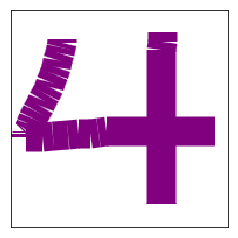

In [13]:
# See what hand-drawn digit the sample data represents
#
rgba_arr = np.asarray( sample_cavas_data["data"] ).astype('uint8')
n = sample_cavas_data["height"]
plt.figure()
plt.imshow( rgba_arr.reshape( n, n, 4 ) )
plt.xticks([])
plt.yticks([])
plt.show()

## <a id="step5"></a> 5. Create a deployable function

The basics of creating and deploying functions in Watson Machine Learning are given here:
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-deploy-functions.html" target="_blank" rel="noopener noreferrer">Creating and deploying functions</a>
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-functions.html" target="_blank" rel="noopener noreferrer">Implementation details of deployable functions</a>


### 5.1 Define the function
1. Define a Python closure with an inner function named "score".
2. Use default parameters to save your Watson Machine Learning credentials and the model deployment endpoint URL with the deployed function.
3. Process the canvas data (reshape and normalize) and then send the processed data to the model deployment.
4. Process the results from the model deployment so the deployed function returns simpler results.
5. Implement error handling so the function will behave gracefully if there is an error.

In [14]:
ai_parms = { "wml_credentials" : wml_credentials, "model_deployment_endpoint_url" : model_deployment_endpoint_url }

def my_deployable_function( parms=ai_parms ):
    
    try:
        
        import subprocess
        subprocess.check_output( "pip install Pillow --user", stderr=subprocess.STDOUT, shell=True )
        
    except subprocess.CalledProcessError as e:        
        install_err = "subprocess.CalledProcessError:\n\n" + "cmd:\n" + e.cmd + "\n\noutput:\n" + e.output.decode()
        raise Exception( "Installing failed:\n" + install_err )
    
        
    def getRGBAArr( canvas_data ):
        import numpy as np
        dimension = canvas_data["height"]
        rgba_data = canvas_data["data"]
        rgba_arr  = np.asarray( rgba_data ).astype('uint8')
        return rgba_arr.reshape( dimension, dimension, 4 )
        
    def getNormAlphaList( img ):
        import numpy as np
        alpha_arr       = np.array( img.split()[-1] )
        norm_alpha_arr  = alpha_arr / 255
        norm_alpha_list = norm_alpha_arr.reshape( 1, 784 ).tolist()
        return norm_alpha_list
        
    def score( function_payload ):
            
        try:
            
            from PIL import Image
            canvas_data   = function_payload["values"][0]           # Read the payload received by the function
            rgba_arr      = getRGBAArr( canvas_data )               # Create an array object with the required shape
            img           = Image.fromarray( rgba_arr, 'RGBA' )     # Create an image object that can be resized
            sm_img        = img.resize( ( 28, 28 ), Image.LANCZOS ) # Resize the image to 28 x 28 pixels
            alpha_list    = getNormAlphaList( sm_img )              # Create a 1 x 784 array of values between 0 and 1
            model_payload = { "values" : alpha_list }               # Create a payload to be sent to the model
                    
            #print( "Payload for model:" ) # For debugging purposes
            #print( model_payload )        # For debugging purposes
                    
            from watson_machine_learning_client import WatsonMachineLearningAPIClient
            client       = WatsonMachineLearningAPIClient( parms["wml_credentials"] )
            model_result = client.deployments.score( parms["model_deployment_endpoint_url"], model_payload )
            digit_class  = model_result["values"][0]
                    
            return { "digit_class" : digit_class }
            
        except Exception as e:
            
            return { "error" : repr( e ) }


    return score

### 5.2 Test locally
You can test your function in the notebook before deploying the function.

To see debugging info:
1. Uncomment the print statements inside the score function
2. Rerun the cell defining the function
3. When you rerun the this cell, you will see the debugging info

In [15]:
# Pass the sample canvas data to the function as a test
#
func_result = my_deployable_function()( { "values" : [ sample_cavas_data ] } )
print( func_result )

{'digit_class': 4}


## <a id="step6"></a> 6. Store and deploy the function
Before you can deploy the function, you must store the function in your Watson Machine Learning repository.

In [16]:
# Store the deployable function in your Watson Machine Learning repository
#
meta_data = { client.repository.FunctionMetaNames.NAME : 'MNIST deployable function' }
function_details = client.repository.store_function( meta_props=meta_data, function=my_deployable_function )

No RUNTIME_UID passed. Creating default runtime... SUCCESS

Successfully created default runtime with uid: 66b52400-94d0-4301-929c-36dd0ddf23c2


In [17]:
# Deploy the stored function
#
function_id = function_details["metadata"]["guid"]
function_deployment_details = client.deployments.create( artifact_uid=function_id, name="MNIST function deployment" )



#######################################################################################

Synchronous deployment creation for uid: 'ad6cd627-a84b-4c61-88a4-fc9e599213ef' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS......
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='65175e0e-a90e-4031-90d5-62dd5d70aae4'
------------------------------------------------------------------------------------------------




## <a id="step7"></a> 7. Test the deployed function

You can use the Watson Machine Learning Python client or REST API to send data to your function deployment for processing in exactly the same way you send data to model deployments for processing.

In [18]:
# Get the endpoint URL of the function deployment just created
#
function_deployment_endpoint_url = client.deployments.get_scoring_url( function_deployment_details )
function_deployment_endpoint_url

'https://us-south.ml.cloud.ibm.com/v3/wml_instances/d0755448-6eb4-425a-b35b-479be91ff2d5/deployments/65175e0e-a90e-4031-90d5-62dd5d70aae4/online'

In [19]:
payload = { "values" : [ sample_cavas_data ] }

### 7.1 Watson Machine Learning Python client

In [20]:
result = client.deployments.score( function_deployment_endpoint_url, payload )
if "error" in result:
    print( result["error"] )
else:
    print( result )

{'digit_class': 4}


### 7.2 Watson Machine Learning REST API example

In [21]:
# Get a bearer token
url = wml_credentials["url"] + "/v3/identity/token"
response = requests.get( url, auth=( wml_credentials["username"], wml_credentials["password"] ) )
mltoken = json.loads( response.text )["token"]

# Send sample canvas data to function deployment for processing
header = { 'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken }
response = requests.post( function_deployment_endpoint_url, json=payload, headers=header )
print ( response.text )

{"digit_class": 4}



## Summary and next steps
In this notebook, you created a Python function that receives HTML canvas image data and then processes and sends that data to a model trained to recognize handwritten digits.

To learn how you can use this deployed function in a web app, see:
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-nodejs-mnist-tutorial.html" target="_blank" rel="noopener noreferrer">Sample Node.js app that recognizes hand-drawn digits</a>
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-python-flask-mnist-tutorial.html" target="_blank" rel="noopener noreferrer">Sample Python Flask app that recognizes hand-drawn digits</a>

### <a id="authors"></a>Authors

**Sarah Packowski** is a member of the IBM Watson Studio Content Design team in Canada.


<hr>
Copyright &copy; IBM Corp. 2018. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>